In [1]:
from deeppavlov.models.bidirectional_lms import elmo_bilm
from deeppavlov.models.tokenizers.lazy_tokenizer import LazyTokenizer
from nltk.tokenize.moses import MosesDetokenizer
import numpy as np
from typing import List
from scipy.stats import kurtosis


import pandas as pd

[nltk_data] Downloading package punkt to /home/sultanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!
[nltk_data] Downloading package nonbreaking_prefixes to
[nltk_data]     /home/sultanov/nltk_data...
[nltk_data]   Package nonbreaking_prefixes is already up-to-date!


In [2]:
class ElmoAug:
    
    def __init__(self, model_dir="/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news"):
        self.tokenizer = LazyTokenizer()
        self.elmo_lm   = elmo_bilm.ELMoEmbedder(model_dir=model_dir)
        self.detokenizer = MosesDetokenizer()
        self.tmp_logger = []
        self.logger = []
        
    def _multi_argmax(self, values: np.ndarray, n_instances: int = 1) -> np.ndarray:
        """
        Selects the indices of the n_instances highest values.
        Args:
            values: Contains the values to be selected from.
            n_instances: Specifies how many indices to return.
        Returns:
            Contains the indices of the n_instances largest values.
        """
        assert n_instances <= values.shape[0], 'n_instances must be less or equal than the size of utility'

        max_idx = np.argpartition(-values, n_instances-1, axis=0)[:n_instances]
        return max_idx
    
    def _weighted_sum_distr_by_posistion_in_sent(self, distr):
        weights = (np.arange(len(distr)) + 0.5)/len(distr)
        left = distr[:,0,:]
        right = distr[:,1,:]
        right = right.transpose([1, 0]) * (1-weights)
        right = right.transpose([1, 0])
        left = left.transpose([1, 0]) * weights
        left = left.transpose([1, 0])
        return right + left
    
    def _select_informative_context(self, distr, num_method):
        """
        method 0:
            Kurtosis
        method 1:
            maximum
        method 2:
            minimum along top words
        method 3: random
        """
        left = distr[:, 0, :]
        right = distr[:, 1, :]
        
        if num_method == 0:
            method_func = lambda x: kurtosis(x)
        if num_method == 1:
            method_func = lambda x: np.max(x)
        if num_method == 2:
            method_func = lambda x: np.msort(x)[-5]###5??????
        if num_method == 3:
            return np.array([left[i] if np.random.randint(0, 2) else right[i] for i in range(len(distr))])
            
        
        result_distr = []
        left_func_values = [method_func(l) for l in left]
        right_func_values = [method_func(r) for r in right]
        for i in range(len(left_func_values)):
            if left_func_values[i] > right_func_values[i]:
                result_distr.append(left[i])
            elif left_func_values[i] < right_func_values[i]:
                result_distr.append(right[i])
            else:
                if np.random.randint(0, 2) == 0:
                    result_distr.append(left[i])        
                else:
                    result_distr.append(right[i])
        return np.array(result_distr)


    def _blend_dist(self, batch_distr, num_method):
        """
        blending distr from left and right context
        method 0:
            sum two distr along left right context
        method 1:
            weighted sum by place of word in sentence
        method 2:
            only left context
        method 3:
            only right context
        method 4:
            or left or right context, select basing on 
            method 0:
            method 1:
            method 2:
        method 7:
            random side
        """
        if num_method == 0:
            return [np.sum(distr, axis=1) for distr in batch_distr]
        
        elif num_method == 1:
            return [self._weighted_sum_distr_by_posistion_in_sent(distr) for distr in batch_distr]
        
        elif num_method == 2:
            return [distr[:,0,:] for distr in batch_distr]
        
        elif num_method == 3:
            return [distr[:,1,:] for distr in batch_distr]
        
        elif num_method == 4:
            return [self._select_informative_context(distr, 0) for distr in batch_distr]
        
        elif num_method == 5:
            return [self._select_informative_context(distr, 1) for distr in batch_distr]
        
        elif num_method == 6:
            return [self._select_informative_context(distr, 2) for distr in batch_distr]
        
        elif num_method == 7:
            return [self._select_informative_context(distr, 3) for distr in batch_distr]
    
    def _softmax(self, x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum()
    
    def _sample_distr(self, distr):
        """Sampling from given distribution"""
        threshold = np.random.random_sample()
        i = 0
        while threshold - distr[i] > 0:
            threshold -= distr[i]
            i += 1
        return i
    
    def _sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        my_true = 0#+
        my_sum = 0#+
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]    
                p = self._softmax([distr[i, index] for index in self._multi_argmax(distr[i], n_top_words)])
                #result.append(words[self._sample_distr(p)])
                word = words[self._sample_distr(p)]#+
                result.append(word)#+
                if token in words:#1
                    my_true += 1#1
                    my_sum += 1#1
                else:#1
                    my_sum += 1#1
            else:
                result.append(token)
        self.tmp_logger.append({'true': my_true, 'sum': my_sum})#+
        return result
    
    def _rand_sent_aug(self, source_sentence, distr, n_top_words, replace_freq: float=1):
        result = []
        my_true = 0#+
        my_sum = 0#+
        for i, token in enumerate(source_sentence):
            if np.random.rand() < replace_freq:
                words = [self.elmo_lm.get_vocab()[index] for index in self._multi_argmax(distr[i], n_top_words)]
                #result.append(words[np.random.randint(0, len(words))])
                word = words[np.random.randint(0, len(words))]#1
                result.append(word)#1
                if token in words:#1
                    my_true += 1#1
                    my_sum += 1#1
                else:#1
                    my_sum += 1#1
            else:
                result.append(token)
        self.tmp_logger.append({'true': my_true, 'sum': my_sum})#+
        return result

    
    def _batch_sent(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int) -> List[str]:
        """
        Replaces some words in the original sentence with words from the language model with frequency p
        Args:
            batch_token: Sentences to be augmented 
            n_top_words: The number of the most likely words from the language model that will be considered as a replacement for the original.
            p: frequency of replacing words
        Returns:
            Contains the augmented sentences
        """
        batch_token    = self.tokenizer(batch_sent)
        batch_distr = self._blend_dist(self.elmo_lm(batch_token), num_method_blend)
        if num_method_blend != 7:
            batch_aug_token = [self._sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        else:
            batch_aug_token = [self._rand_sent_aug(batch_token[i], batch_distr[i], n_top_words, replace_freq) for i in range(len(batch_token))]
        self.logger.append({'method': num_method_blend, **pd.DataFrame(self.tmp_logger).sum().to_dict()})
        self.tmp_logger = []
        return batch_aug_token        
    
    def __call__(self, batch_sent: List[str], n_top_words: int, replace_freq: float, num_method_blend: int):
        batch_aug_token = self._batch_sent(batch_sent, n_top_words, replace_freq, num_method_blend)
        return [self.detokenizer.detokenize(i, return_str=True) for i in batch_aug_token]

In [3]:
el = ElmoAug()

Using TensorFlow backend.


****************************************************************************************************
/cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news
Instructions for updating:
Use the `axis` argument instead


2018-10-23 11:26:57.692 WARNING in 'tensorflow'['tf_logging'] at line 125: From /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/bilm/training.py:217: calling squeeze (from tensorflow.python.ops.array_ops) with squeeze_dims is deprecated and will be removed in a future version.
Instructions for updating:
Use the `axis` argument instead


USING SKIP CONNECTIONS
INFO:tensorflow:Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


2018-10-23 11:26:58.228 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from /cephfs/home/sultanov/elmo_lm/lib/python3.6/site-packages/download/bidirectional_lms/elmo_en_news/model.ckpt-935588


In [4]:
test_sentences = \
["Almost half of all iPhone owners have broken their screens, not just once but an average of two times each.",\
   "i really don't understand your point.\xa0 It seems that you are mixing apples and oranges.",\
   "shut the fuck up. you and the rest of your faggot friends should be burned at the stake",\
   "That you are an idiot who understands neither taxation nor women's health.",\
   "What on Earth is that about? Is it what's going to get him fired eventually?",\
   "This is a doctrine of constitutional interpretation that says that a constitution is organic and must be read in a broad and liberal manner so as to adapt it to changing times.",\
   "In the 2000s, music notation typically means the written expression of music notes and rhythms on paper using symbols.",\
   "Most of the mathematical notation in use today was not invented until the 16th century.[52] Before that, mathematics was written out in words, limiting mathematical discovery.",\
   "Physical geography deals with the study of processes and patterns in the natural environment like the atmosphere, hydrosphere, biosphere, and geosphere.",\
   "An autobiography is written by the person himself or herself, sometimes with the assistance of a collaborator or ghostwriter."]

In [5]:
%%time
for blend_method in range(8):
    el(test_sentences*10, 5, 1, blend_method)

CPU times: user 1d 3h 56min 13s, sys: 4h 47min 2s, total: 1d 8h 43min 15s
Wall time: 54min 16s


In [6]:
data = pd.DataFrame(el.logger)
data['acc'] = data['true']/data['sum']
data

,method,sum,true,acc
0,0,2240,1313,0.586161
1,1,2240,1295,0.578125
2,2,2240,1074,0.479464
3,3,2240,1065,0.475446
4,4,2240,1112,0.496429
5,5,2240,1173,0.523661
6,6,2240,1077,0.480804
7,7,2240,1066,0.475893


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

2018-10-23 12:21:19.416 DEBUG in 'matplotlib'['__init__'] at line 415: CACHEDIR=/home/sultanov/.cache/matplotlib
2018-10-23 12:21:19.418 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1359: Using fontManager instance from /home/sultanov/.cache/matplotlib/fontlist-v300.json
2018-10-23 12:21:19.498 DEBUG in 'matplotlib.pyplot'['pyplot'] at line 211: Loaded backend module://ipykernel.pylab.backend_inline version unknown.
2018-10-23 12:21:19.515 DEBUG in 'matplotlib.pyplot'['pyplot'] at line 211: Loaded backend module://ipykernel.pylab.backend_inline version unknown.


2018-10-23 13:04:44.979 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-23 13:04:45.114 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-23 13:04:45.139 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-23 13:04:45.253 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-23 13:04:45.285 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos
2018-10-23 13:04:45.304 DEBUG in 'matplotlib.axes._base'['_base'] at line 2491: update_title_pos


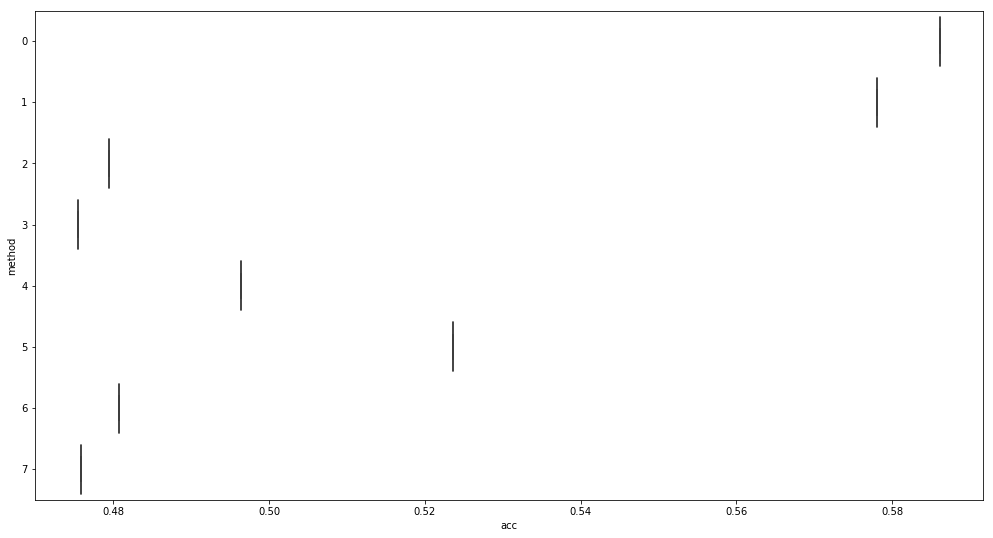

In [13]:
plt.figure(figsize=(17,9))
sns.boxplot(x='acc', y='method', data=data, orient='h')
plt.savefig('./exzA:top-5.png')

In [9]:
from json import JSONEncoder

In [10]:
j = JSONEncoder()

In [11]:
with open('./A_result_exp.json', 'w') as f:
    f.write(j.encode(el.logger))

In [12]:
#ddd.shape == (batch:3, len_sent:4, left_right:2, vocab_size:5)
#left = data[0][:, 0, :]
#right = data[0][:, 1, :]
#right.shape
#
#data = [np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]],\
#        [[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]]]),\
#       np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]],\
#        [[1,1,1,1,1],[5,5,5,5,5]]]),\
#       np.array([[[1,1,1,1,1],[5,5,5,5,5]],[[1,1,1,1,1],[5,5,5,5,5]]])]